# Pretrial Detention In Virginia
## Quantifying the Influence of Race and Geography:
### A Bayesian Analysis

**by Brandtly Jones and Eric Tang**

## Introduction
Every year, well over 300,000 individuals are arrested in Virginia for offenses big and small. What happens next can vary widely. Most are released quickly on their own recognizance or with a bond posted to ensure that they return for their court date, but others face pretrial detention, sometimes all the way to trial even before being convicted of a crime.

This analysis will look at the role that race and geography (i.e. judicial circuit) play in determining decisions about pretrial release. While controling for factors that contribute to release conditions, we will seek to detect if racial disparities are evident in the available data concerning pretrial release and if those disparities vary across judicial district. Using partial pooling and hierarchical modeling we intend to evaluate posterior distributions on race and geography as predictors of pretrial treatment of individuals, and thereby quantify the uncertainty in the model.

The data set contains approximately 22,000 de-identified individuals with contact events with the criminal justice system in October of 2017. The data contains over 700 variables, including demographic information about the defendants as well as their criminal history, locality, offense, lawyer type (e.g. public defender or private attorney), and their pretrial outcomes. We have reduced these to a manageable set of predictors and the binary response variable of whether a defendant was held for their entire pretrial period. 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

In [2]:
#initial paring down of full dataset
# df=pd.read_csv("http://www.vcsc.virginia.gov/pretrialdataproject/October%202017%20Cohort_Virginia%20Pretrial%20Data%20Project_Deidentified%20FINAL%20Update_10272021.csv", low_memory=False)

In [110]:
# """
# cols=df.columns
# selected_cols=[item[1] for item in
#     [(2, 'Defendant_Sex'),
#     (3, 'Defendant_Race'),
#     (5, 'Defendant_Age'),
#     (9, 'Defendant_IndigencyStatus'),
#     (12, 'WhetherDefendantWasReleasedPretrial'),
#     (14, 'DaysBetweenContactEventAndPretrialRelease'),
#     (16, 'PretrialReleaseType2'),
#     (17, 'BondTypeAtInitialContact'),
#     (18, 'BondAmountAtInitialContact'),
#     (19, 'BondTypeAtRelease_v1'),
#     (21, 'BondAmountAtRelease'),
#     (25, 'Indicator_PresumptiveDenialOfBail_19.2_120'),
#     (168, 'PriorArrests'),
#     (301, 'Locality_JudicialCircuit'),
#     (303, 'Locality_MagisterialRegion'),
#     (563, 'FollowUp_ChargedWithNewFTA'),
#     (572, 'FollowUp_ArrestedforNewOff'),
#     (708, 'CrimeCommission2021ReportClassificationofDefendants')]]+['VPRAI_TotalPoints_Opt1',
#      'VPRAI_TotalPoints_Opt2',
#      'PSA_FTA_TotalPoints',
#      'PSA_NCA_TotalPoints',
#      'PSA_NVCA_TotalPoints']
#      """

In [4]:
# df[selected_cols].to_csv("SelectPretrialData.csv", index=False)

In [199]:
df=pd.read_csv("SelectPretrialData.csv")

### Cleaning
The overwhelming majority of defendants are identified as white or black, so we will focus just on these.

Pretrial release is coded 0, 1, or 9 for unclear. There are only 30 unknowns, or .13% which won't affect the analysis so these are dropped.

13 records do not include a Judicial Circuit so these are dropped.

In [3]:
cols=['Defendant_Race', 'WhetherDefendantWasReleasedPretrial', 'Locality_JudicialCircuit']
minimal_df=df[cols].query("((Defendant_Race=='W')|(Defendant_Race=='B'))")
minimal_df=minimal_df.query("Locality_JudicialCircuit!=' '")
minimal_df=minimal_df.query("WhetherDefendantWasReleasedPretrial!=9")


### Some overview of the racial breakdown of the data

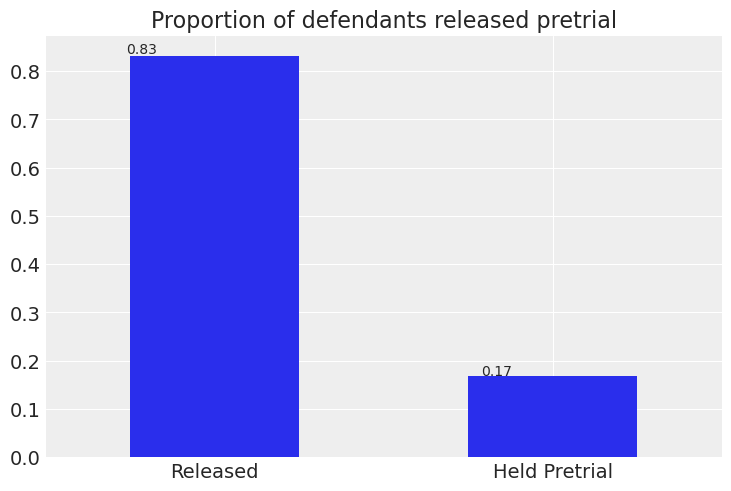

In [105]:
#base rate of pre-trial release for all defendants across Virginia
ax = minimal_df['WhetherDefendantWasReleasedPretrial'].replace({1:"Released",0:"Held Pretrial"}).value_counts(normalize=True).plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.05, p.get_height() * 1.005))
plt.title("Proportion of defendants released pretrial")
plt.xticks(rotation=0)
plt.savefig("Proportion of defendants released pretrial.png")
plt.show()


In [185]:
minimal_df.shape[0]*.17

3818.7100000000005

In [107]:
bw=pd.crosstab(minimal_df['Defendant_Race'],1-minimal_df['WhetherDefendantWasReleasedPretrial'], normalize='index')
bw

WhetherDefendantWasReleasedPretrial,0,1
Defendant_Race,,
B,0.811538,0.188462
W,0.846265,0.153735


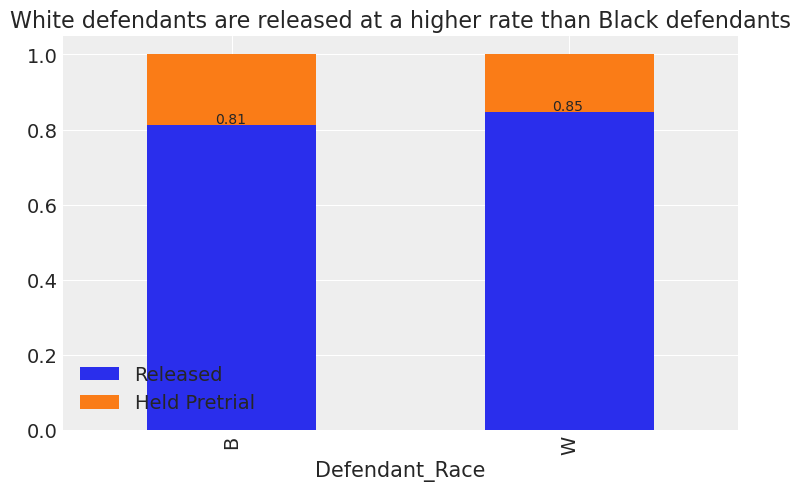

In [108]:
ax=bw.plot.bar(stacked=True)
for p in ax.patches:
    if p.get_height()>.8:
        ax.annotate(str(round(p.get_height(),2)), (p.get_x()+.2, p.get_height() * 1.005))

plt.legend(['Released', 'Held Pretrial'],loc='lower left')
plt.title("White defendants are released at a higher rate than Black defendants")
plt.savefig("White defendants released.png");

### This difference, 81% release rate for Black defendants versus 85% release rate for White defendants, is highly significant (p=1.4e-11).

In [121]:
#test for significance
from scipy.stats import ttest_ind
#define samples
white = minimal_df[minimal_df['Indicator_Black']==0]
black = minimal_df[minimal_df['Indicator_Black']==1]

#perform Welch's two sample t-test
ttest_ind(white['WhetherDefendantWasReleasedPretrial'], black['WhetherDefendantWasReleasedPretrial'], equal_var=False)

Ttest_indResult(statistic=6.766236382685769, pvalue=1.360344934295338e-11)

In [212]:
white.shape

(13172, 4)

In [213]:
black.shape

(9291, 4)

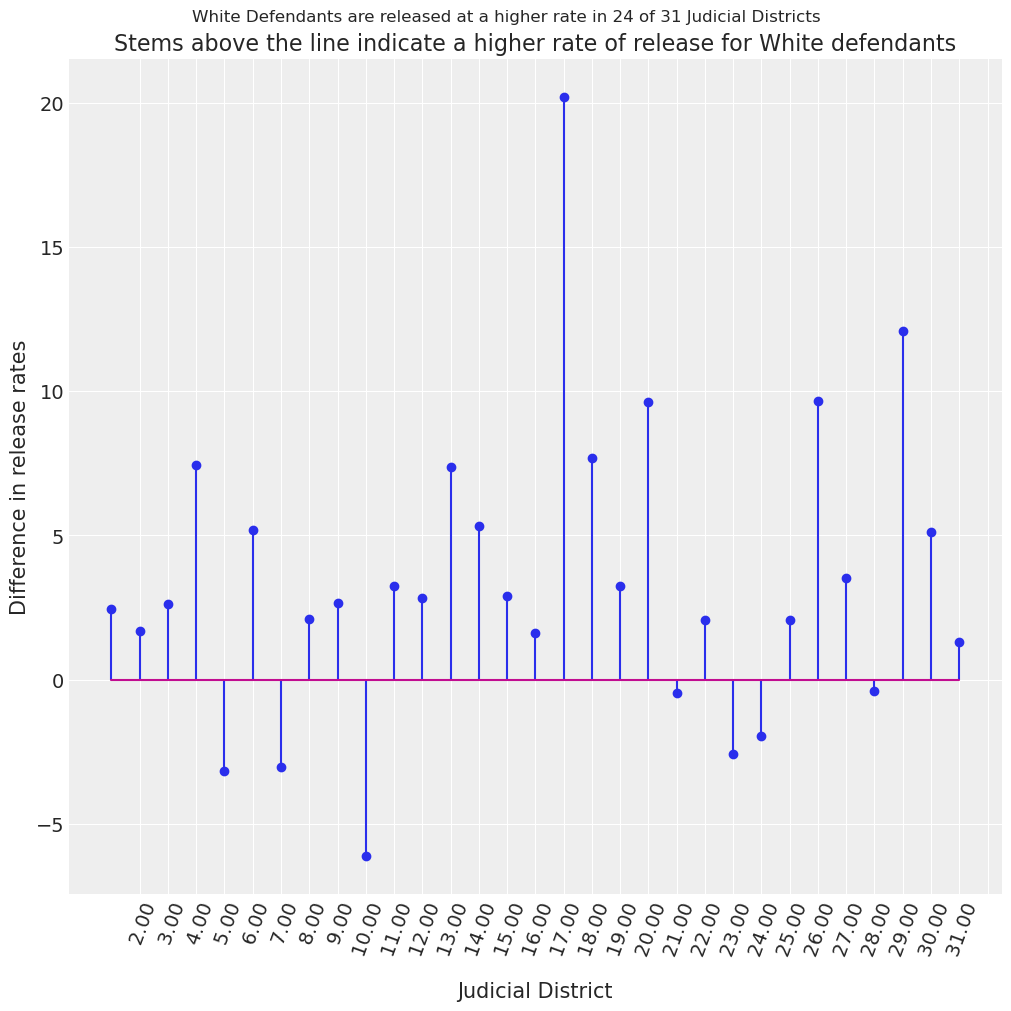

In [109]:
dist_bw=minimal_df.groupby(["Locality_JudicialCircuit",'Defendant_Race']).agg({'WhetherDefendantWasReleasedPretrial':'mean'})
dist_bw=dist_bw.reset_index()
dist_bw_pivot=dist_bw.pivot_table(columns=['Defendant_Race'], index=['Locality_JudicialCircuit'])
dist_bw_pivot['Difference']=100*(dist_bw_pivot['WhetherDefendantWasReleasedPretrial']['W']-dist_bw_pivot['WhetherDefendantWasReleasedPretrial']['B'])
fig, ax=plt.subplots(figsize=(10,10))
plt.stem(dist_bw_pivot.index, dist_bw_pivot['Difference'])
plt.xticks(np.arange(1,32),rotation=70)
plt.ylabel("Difference in release rates")
plt.xlabel("Judicial District")
plt.suptitle("White Defendants are released at a higher rate in 24 of 31 Judicial Districts")
plt.title("Stems above the line indicate a higher rate of release for White defendants")
plt.savefig("District differences.png");


So just looking at proportions we have an intuition that there may be variation in treatment of defendants based on race in the overall population, and that we may have some districts where that difference is more pronounced.

To investigate this phenomenon we will apply a hierarchical model to the data. 

In [132]:
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')
SEED = 20190518 # from random.org, for reproducibility
np.random.seed(SEED)
import scipy as sp

In [133]:
minimal_df['Indicator_Black']=(minimal_df['Defendant_Race']=='B').astype(int)
jud_districts = minimal_df.Locality_JudicialCircuit.unique()
districts = len(jud_districts) 
district = minimal_df['Locality_JudicialCircuit'].values.astype(float).astype(int)-1
np.unique(district)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

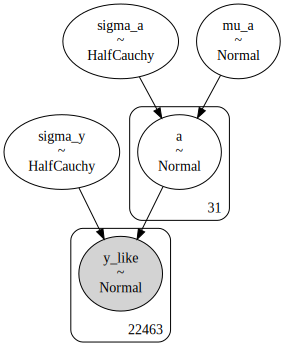

In [134]:
with pm.Model() as partial_pooling:

    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    sigma_a = pm.HalfCauchy('sigma_a', 5)

    # Random intercepts
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=districts)

    # Model error
    sigma_y = pm.HalfCauchy('sigma_y',5)

    # Expected value
    y_hat = a[district]

    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=minimal_df['WhetherDefendantWasReleasedPretrial'])

pm.model_to_graphviz(partial_pooling)

In [205]:
# with partial_pooling:
#     advi_part_pool=pm.fit(40000, method = 'advi', random_seed = SEED)

In [204]:
# advi_elbo = pd.DataFrame(
#     {'ELBO': -advi_part_pool.hist,
#      'n': np.arange(advi_part_pool.hist.shape[0])})

# _=sns.lineplot(y='ELBO', x='n', data=advi_elbo)

We see really strong convergence with ADVI.

In [203]:
# az.summary(advi_part_pool.sample(), round_to=2)

In [202]:
# az.plot_forest(advi_part_pool.sample());

In [201]:
# az.plot_trace(advi_part_pool.sample(10000));

In [200]:
# az.summary(sample_trace)

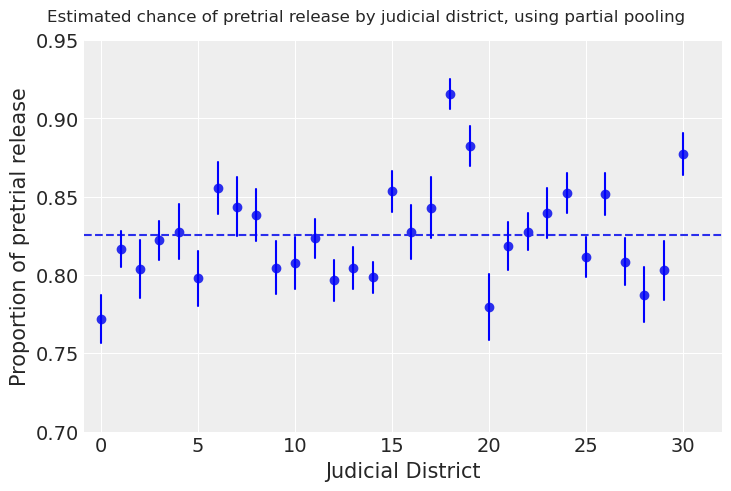

In [140]:
sample_trace = advi_part_pool.sample().posterior['a']
_, sample, districts=sample_trace.shape
jitter = np.random.normal(scale=0.01, size=districts)

means = sample_trace.mean(axis=1)[0,:]
sd = sample_trace.std(axis=1)[0,:]
fig, ax=plt.subplots()
ax.scatter(np.arange(31), means)
#ax.set_xscale('log')
ax.set_xlim(-0.9,32)
ax.set_ylim(0.7, 0.95)
ax.hlines(sample_trace.mean(), -0.9, 32, linestyles='--')
ax.set_ylabel("Proportion of pretrial release")
ax.set_xlabel("Judicial District")
plt.suptitle("Estimated chance of pretrial release by judicial district, using partial pooling")

for j,n,m,s in zip(jitter, np.arange(31), means, sd):
    ax.plot([n]*2, [m-s, m+s], 'b-')

In [198]:
# dist_only=minimal_df.groupby('Locality_JudicialCircuit').agg({'WhetherDefendantWasReleasedPretrial':'describe'})
# dist_only
#np.sqrt(0.760450*(1-0.760450)/622)*1.96

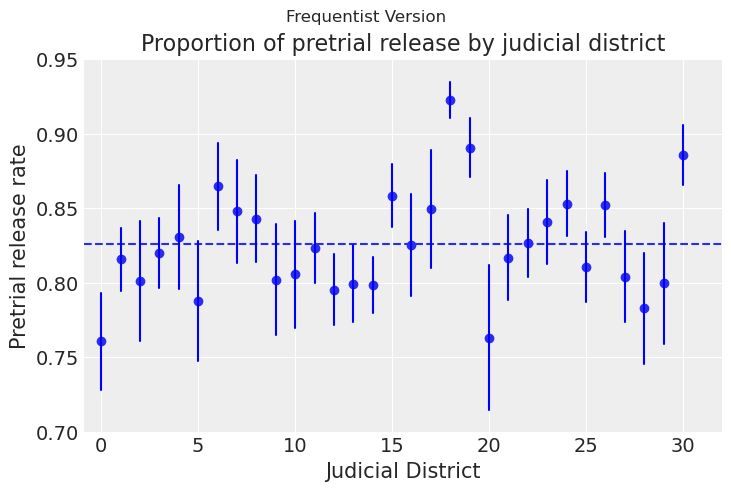

In [153]:
mean=minimal_df['WhetherDefendantWasReleasedPretrial'].mean()
means=dist_only['WhetherDefendantWasReleasedPretrial']['mean'].values
sd=1.881*dist_only['WhetherDefendantWasReleasedPretrial']['std']/np.sqrt(dist_only['WhetherDefendantWasReleasedPretrial']['count']).values
fig, ax=plt.subplots()
ax.scatter(np.arange(31), means)
#ax.set_xscale('log')
ax.set_xlim(-0.9,32)
ax.set_ylim(0.7, .95)
ax.hlines(sample_trace.mean(), -0.9, 32, linestyles='--')
ax.set_ylabel("Pretrial release rate")
ax.set_xlabel("Judicial District")
plt.title("Proportion of pretrial release by judicial district")
plt.suptitle("Frequentist Version")
for j,n,m,s in zip(jitter, np.arange(31), means, sd):
    ax.plot([n]*2, [m-s, m+s], 'b-')

## Varying intercept and slope model

In [9]:
with pm.Model() as varying_intercept_slope:
    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    sigma_a = pm.Exponential("sigma_a", 0.5)
    mu_b = pm.Normal('mu_b', mu=0., sigma=1e5)
    sigma_b = pm.HalfCauchy('sigma_b', 5)
    
    #sigma_b = pm.Exponential("sigma_b", .05)
    # Random intercepts
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=districts)
    # Random slopes
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=districts)
    # Model error
    sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)
    # Expected value
    y_hat = a[district] + b[district] * minimal_df['Indicator_Black'].values
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=minimal_df['WhetherDefendantWasReleasedPretrial'].values)
    
    
    step = pm.NUTS(target_accept=0.9)
    varying_intercept_slope_trace=pm.sample(8000, step = step, random_seed = SEED)

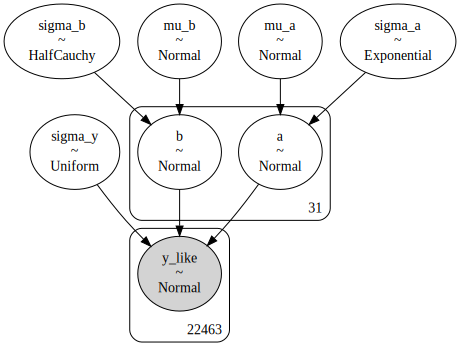

In [47]:
    
pm.model_to_graphviz(varying_intercept_slope)

Our model:
$$Release_{i,\ell} = \alpha_{\ell} + \beta_{\ell} * Indicator\_Black_{i,\ell} + \epsilon_{\ell}$$

$$\alpha_{\ell} \sim \mathcal{N}(\mu_{\alpha}, \sigma^{2}_{\alpha});  \mu_{\alpha}\sim \mathcal{N}(0, 1e5), \sigma_{\alpha}\sim \mathcal{Exp}(0.5)$$
$$\beta_{\ell} \sim \mathcal{N}(\mu_{\beta}, \sigma^{2}_{\beta});  \mu_{\beta}\sim \mathcal{N}(0, 1e5), \sigma_{\beta}\sim \mathcal{HalfCauchy}(5)$$

$$\epsilon_{\ell}\sim \mathcal{Unif}[0,100]$$


In [197]:
# az.plot_forest(varying_intercept_slope_trace);

In [196]:
# with varying_intercept_slope:
#     pm.plot_trace(varying_intercept_slope_trace)

In [195]:
# varying_intercept_slope_trace

In [194]:
# County predictions
# xvals = np.arange(2)
# b = varying_intercept_slope_trace.posterior.a.mean(axis=1).mean(axis=0).values
# m = varying_intercept_slope_trace.posterior.b.mean(axis=1).mean(axis=0).values
# plt.figure(figsize = (8,10))
# for bi,mi in zip(b,m):
#     plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
#     plt.xlim(-0.1, 1.1)
#     plt.xlabel("Black Indicator")
#     plt.ylabel("Proportion released pretrial per judicial circuit")
# plt.savefig("District_outcomes_for_black_defendants.png");

## A more granular look: differences among the 127 named localities

In [50]:
localities_cols=['Defendant_Race', 'WhetherDefendantWasReleasedPretrial','Locality_Name']

In [52]:
locality_df=pd.read_csv("~/MSDS/Pretrial Detention Capstone/October 2017 Cohort_Virginia Pretrial Data Project_Deidentified FINAL Update_10272021.csv", usecols=localities_cols)

In [65]:
locality_df=locality_df.query("((Defendant_Race=='W')|(Defendant_Race=='B'))")
locality_df=locality_df.query("Locality_Name!=' '")
locality_df=locality_df.query("WhetherDefendantWasReleasedPretrial!=9")
locality_df['Indicator_Black']=(locality_df['Defendant_Race']=='B')

In [59]:
# lookup table (dict) for each county


localities=locality_df.Locality_Name.unique()
num_local=locality_df.Locality_Name.nunique()
local_lookup=dict(zip(localities, range(num_local)))

In [62]:
locality_df['Locality_Number']=locality_df.Locality_Name.map(local_lookup)

In [112]:
localities=locality_df['Locality_Number'].values
local_names=locality_df.Locality_Name.values

array(['Alexandria City', 'Alexandria City', 'Arlington County', ...,
       'Roanoke City', 'Roanoke City', 'Virginia Beach City'],
      dtype=object)

In [114]:
with pm.Model() as localities_model:
    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    sigma_a = pm.Exponential("sigma_a", 0.5)
    mu_b = pm.Normal('mu_b', mu=0., sigma=1e5)
    sigma_b = pm.HalfCauchy('sigma_b', 5)
    
    #sigma_b = pm.Exponential("sigma_b", .05)
    # Random intercepts
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=num_local)
    # Random slopes
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=num_local)
    # Model error
    sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)
    # Expected value
    y_hat = a[localities] + b[localities] * locality_df['Indicator_Black'].values
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=locality_df['WhetherDefendantWasReleasedPretrial'].values)
    
    
    step = pm.NUTS(target_accept=0.9)
    varying_intercept_slope_trace=pm.sample(8000, step = step, random_seed = SEED)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, a, b, sigma_y]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 337 seconds.


In [192]:
#pm.model_to_graphviz(localities_model)

In [191]:
# with localities_model:
#     pm.plot_trace(varying_intercept_slope_trace)

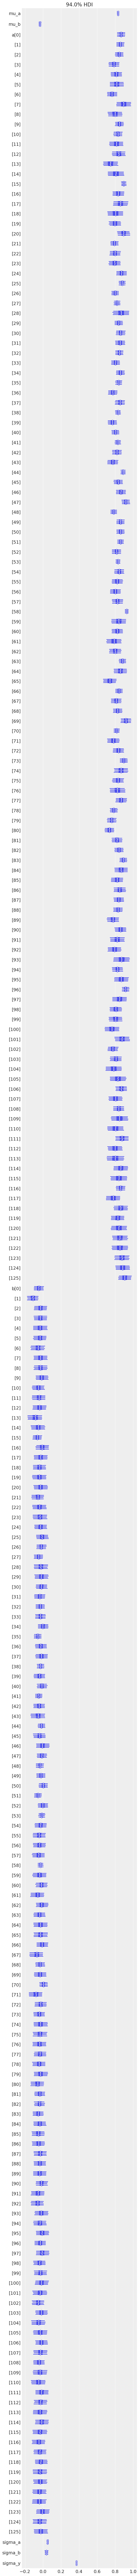

In [232]:
az.plot_forest(varying_intercept_slope_trace);

In [73]:
locality_summary=az.summary(varying_intercept_slope_trace)

In [96]:
locality_summary.loc[locality_summary['mean']< -.056].sort_values('mean')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[1],-0.112,0.033,-0.176,-0.053,0.001,0.0,2239.0,2769.0,1.0
b[13],-0.087,0.043,-0.170,-0.011,0.001,0.0,4221.0,11471.0,1.0
b[71],-0.080,0.040,-0.155,-0.009,0.001,0.0,5118.0,12015.0,1.0
b[67],-0.070,0.040,-0.150,-0.001,0.000,0.0,7767.0,14886.0,1.0
b[15],-0.063,0.026,-0.113,-0.014,0.000,0.0,11492.0,18885.0,1.0
b[80],-0.061,0.039,-0.136,0.010,0.000,0.0,11217.0,13927.0,1.0
b[61],-0.060,0.039,-0.137,0.012,0.000,0.0,12038.0,12130.0,1.0
b[92],-0.060,0.037,-0.132,0.008,0.000,0.0,11634.0,15263.0,1.0
b[35],-0.057,0.022,-0.099,-0.018,0.000,0.0,12737.0,19083.0,1.0
b[91],-0.057,0.039,-0.130,0.016,0.000,0.0,14945.0,13087.0,1.0


In [151]:
no_zero=locality_summary.loc[locality_summary['hdi_97%']< -.0].sort_values('mean').index.str.extract("(\d+)").values.astype(float).astype(int)
pd.DataFrame({'Localities with non-zero coefficients':[key for key, val in local_lookup.items() if val in no_zero]})

,Localities with non-zero coefficients
0,Arlington County
1,Greensville County
2,Loudoun County
3,Stafford County
4,Richmond City
5,Henrico County
6,Norfolk City
7,Warren County
8,Accomack County


In [231]:
just_betas=[f'b[{i}]' for i in range(127)]
locality_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_a,0.833,0.006,0.821,0.845,0.0,0.0,16805.0,22222.0,1.0
mu_b,-0.033,0.008,-0.048,-0.019,0.0,0.0,8616.0,14507.0,1.0
a[0],0.866,0.023,0.822,0.909,0.0,0.0,30115.0,24898.0,1.0
a[1],0.858,0.023,0.815,0.900,0.0,0.0,5868.0,13753.0,1.0
a[2],0.845,0.024,0.799,0.891,0.0,0.0,42143.0,22550.0,1.0
...,...,...,...,...,...,...,...,...,...
b[124],-0.036,0.039,-0.113,0.038,0.0,0.0,42167.0,17246.0,1.0
b[125],-0.023,0.039,-0.099,0.051,0.0,0.0,32052.0,16514.0,1.0
sigma_a,0.052,0.006,0.042,0.063,0.0,0.0,9996.0,16085.0,1.0
sigma_b,0.039,0.010,0.020,0.059,0.0,0.0,1044.0,719.0,1.0


In [152]:
top_diff=locality_summary.loc[locality_summary['mean']< -.056].sort_values('mean').index.str.extract("(\d+)").values.astype(int)
pd.DataFrame({"Localities with steepest slopes":[key for key, val in local_lookup.items() if val in top_diff]})

,Localities with steepest slopes
0,Arlington County
1,Greensville County
2,Loudoun County
3,Richmond City
4,Lunenburg County
5,Warren County
6,Accomack County
7,Bristol City
8,Southampton County
9,Brunswick County


In [218]:
locality_df.groupby('Locality_Name').size().sort_values()

Locality_Name
Bath County                 5
Mathews County              7
Highland County             9
Craig County               11
Surry County               12
                         ... 
Prince William County     865
Norfolk City              933
Richmond City            1025
Virginia Beach City      1072
Fairfax County           1723
Length: 126, dtype: int64

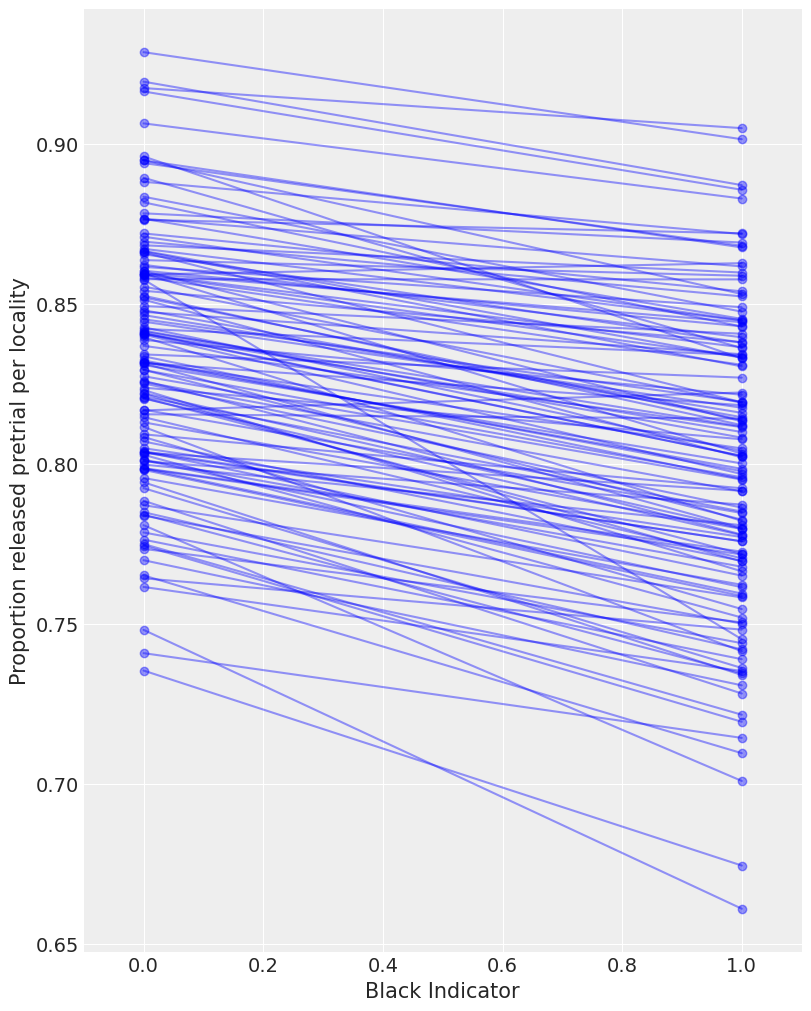

In [69]:
#localities predictions
xvals = np.arange(2)
b = varying_intercept_slope_trace.posterior.a.mean(axis=1).mean(axis=0).values
m = varying_intercept_slope_trace.posterior.b.mean(axis=1).mean(axis=0).values
plt.figure(figsize = (8,10))
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
    plt.xlim(-0.1, 1.1)
    plt.xlabel("Black Indicator")
    plt.ylabel("Proportion released pretrial per locality")
plt.savefig("Localities_outcomes_for_black_defendants.png");

In [211]:
#what was the longest detention for defendants who were released pretrial?
df['DaysBetweenContactEventAndPretrialRelease']=df['DaysBetweenContactEventAndPretrialRelease'].replace({999:np.nan,
                                                                                                        -18:np.nan,
                                                                                                        777:np.nan,
                                                                                                        888:np.nan,
                                                                                                        -1:np.nan})
                                                                                                        
df['DaysBetweenContactEventAndPretrialRelease'] = np.where(df["DaysBetweenContactEventAndPretrialRelease"] > 30, 30, df['DaysBetweenContactEventAndPretrialRelease'])
pd.DataFrame(df.loc[df['WhetherDefendantWasReleasedPretrial']==1,'DaysBetweenContactEventAndPretrialRelease']).value_counts()

DaysBetweenContactEventAndPretrialRelease
1.0                                          1987
30.0                                          623
2.0                                           326
3.0                                           234
4.0                                           201
7.0                                           157
5.0                                           143
6.0                                           143
8.0                                           110
10.0                                           89
9.0                                            82
11.0                                           74
14.0                                           68
12.0                                           64
13.0                                           54
15.0                                           50
16.0                                           48
18.0                                           36
17.0                                           35
22.0    